## Vehicle Insurance Claim Fraud Detection

In this notebook we will be loading the data, analysing feature correlation and importance, handling missing values, feature selection and encoding and finally spliting the dataset into train and test

In [445]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

from sklearn.model_selection import train_test_split

from sklearn.feature_selection import SelectKBest, chi2

In [446]:
data = pd.read_csv('../data/fraud_oracle.csv')

## 1. Data Visualisation and EDA

Lets visualise the data

In [447]:
pd.set_option('display.max_columns', None)
data.head(5)

,Month,WeekOfMonth,DayOfWeek,Make,AccidentArea,DayOfWeekClaimed,MonthClaimed,WeekOfMonthClaimed,Sex,MaritalStatus,Age,Fault,PolicyType,VehicleCategory,VehiclePrice,FraudFound_P,PolicyNumber,RepNumber,Deductible,DriverRating,Days_Policy_Accident,Days_Policy_Claim,PastNumberOfClaims,AgeOfVehicle,AgeOfPolicyHolder,PoliceReportFiled,WitnessPresent,AgentType,NumberOfSuppliments,AddressChange_Claim,NumberOfCars,Year,BasePolicy
0,Dec,5,Wednesday,Honda,Urban,Tuesday,Jan,1,Female,Single,21,Policy Holder,Sport - Liability,Sport,more than 69000,0,1,12,300,1,more than 30,more than 30,none,3 years,26 to 30,No,No,External,none,1 year,3 to 4,1994,Liability
1,Jan,3,Wednesday,Honda,Urban,Monday,Jan,4,Male,Single,34,Policy Holder,Sport - Collision,Sport,more than 69000,0,2,15,400,4,more than 30,more than 30,none,6 years,31 to 35,Yes,No,External,none,no change,1 vehicle,1994,Collision
2,Oct,5,Friday,Honda,Urban,Thursday,Nov,2,Male,Married,47,Policy Holder,Sport - Collision,Sport,more than 69000,0,3,7,400,3,more than 30,more than 30,1,7 years,41 to 50,No,No,External,none,no change,1 vehicle,1994,Collision
3,Jun,2,Saturday,Toyota,Rural,Friday,Jul,1,Male,Married,65,Third Party,Sedan - Liability,Sport,20000 to 29000,0,4,4,400,2,more than 30,more than 30,1,more than 7,51 to 65,Yes,No,External,more than 5,no change,1 vehicle,1994,Liability
4,Jan,5,Monday,Honda,Urban,Tuesday,Feb,2,Female,Single,27,Third Party,Sport - Collision,Sport,more than 69000,0,5,3,400,1,more than 30,more than 30,none,5 years,31 to 35,No,No,External,none,no change,1 vehicle,1994,Collision


We are going to remove PolicyNumber as a feature because its a type of ID and will have no service in training the models

In [448]:
data = data.drop('PolicyNumber',axis=1)

Based on common knowledge we are going to drop the columns that give redundant information or no information at all that will help the models learn

In [449]:
columns = ['Year','WeekOfMonth','DayOfWeek','DayOfWeekClaimed','MonthClaimed','WeekOfMonthClaimed']
for col in columns:
    data = data.drop(col,axis=1)

First we will do a statistical analysis on the features and their distribution depending on the target class.

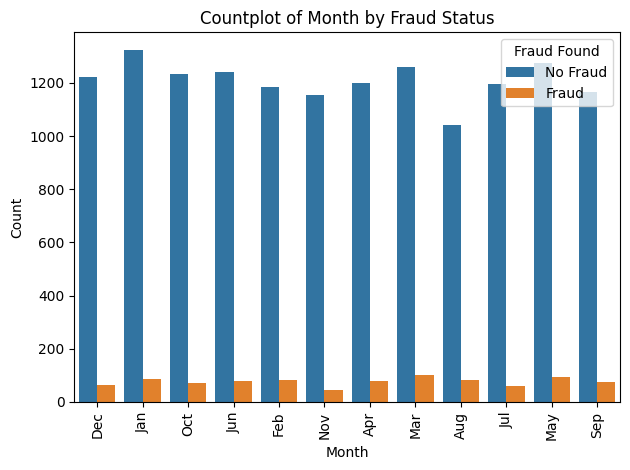

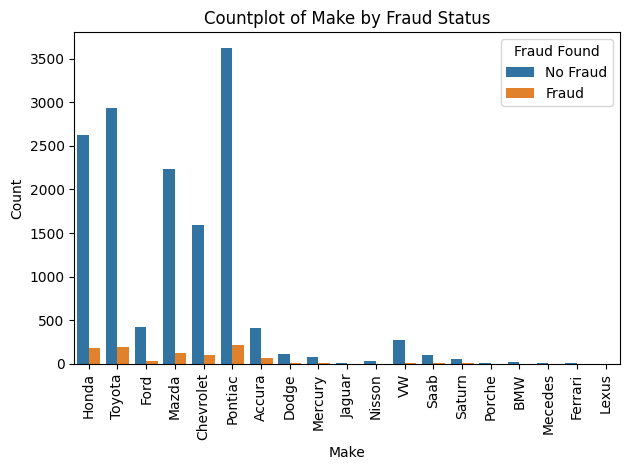

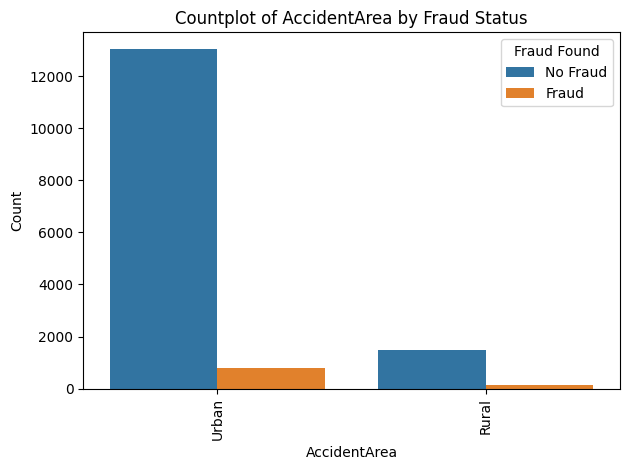

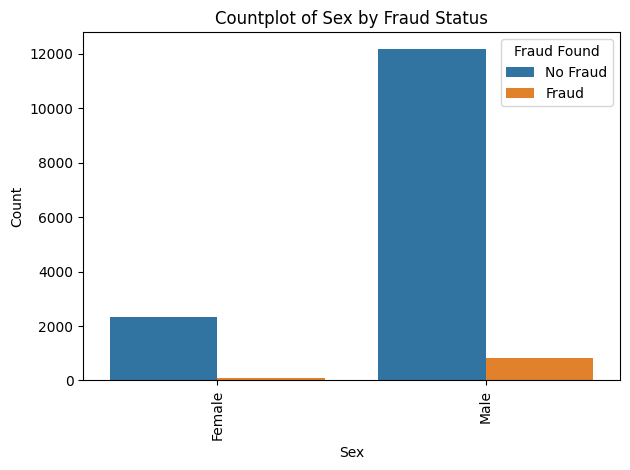

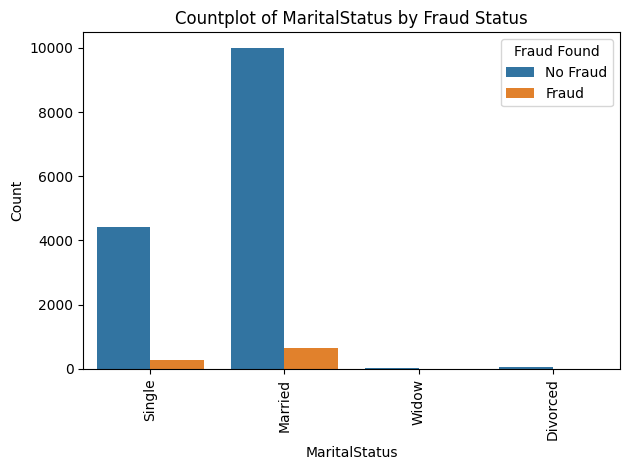

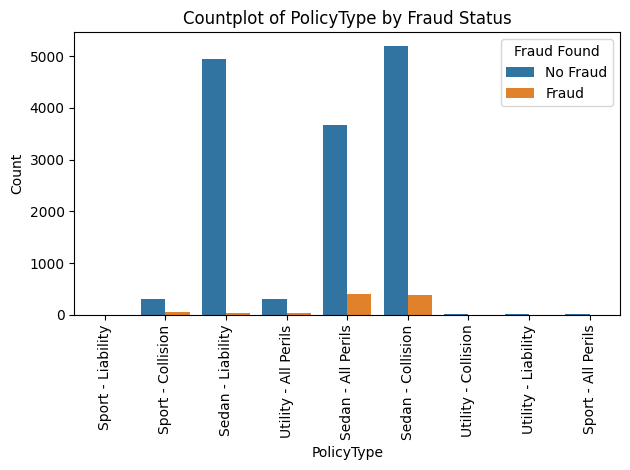

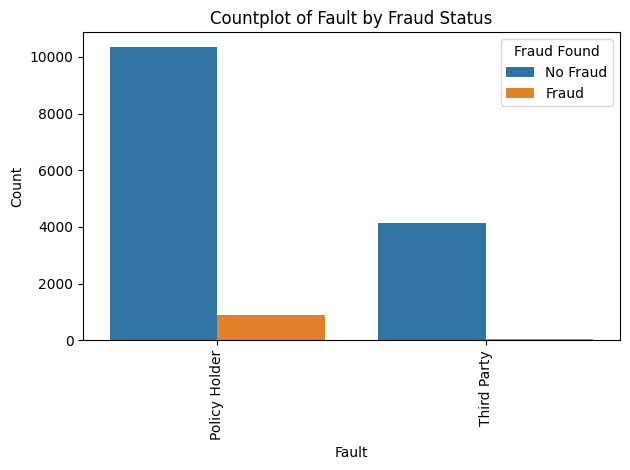

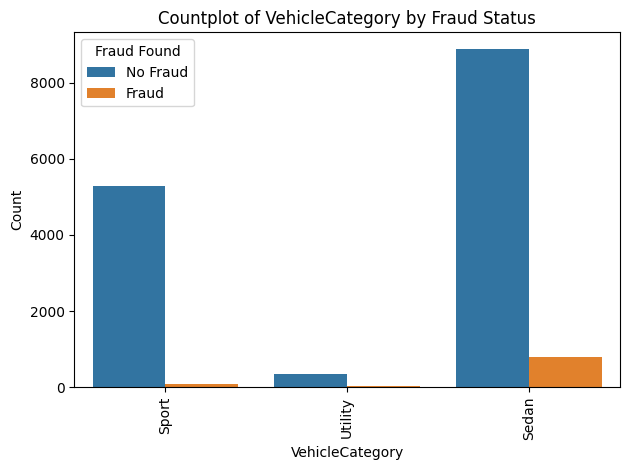

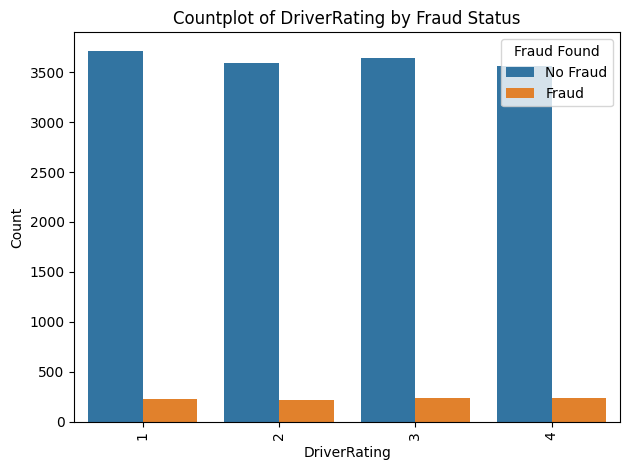

In [450]:
columns=['Month','Make','AccidentArea','Sex','MaritalStatus','PolicyType','Fault','VehicleCategory','DriverRating']
for col in columns:
    sns.countplot(data=data, x=col, hue="FraudFound_P")
    plt.xticks(rotation='vertical')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.title(f'Countplot of {col} by Fraud Status')
    plt.legend(title="Fraud Found", labels=["No Fraud", "Fraud"])
    plt.tight_layout()
    plt.show()

Based on what we see on the histograms, we decided to drop DriverRating and Month because of the pretty uniform distribution of the target class, the models would have very little to learn from

In [451]:
data = data.drop('DriverRating',axis=1)
data = data.drop('Month',axis=1)

In [452]:
data.head()

,Make,AccidentArea,Sex,MaritalStatus,Age,Fault,PolicyType,VehicleCategory,VehiclePrice,FraudFound_P,RepNumber,Deductible,Days_Policy_Accident,Days_Policy_Claim,PastNumberOfClaims,AgeOfVehicle,AgeOfPolicyHolder,PoliceReportFiled,WitnessPresent,AgentType,NumberOfSuppliments,AddressChange_Claim,NumberOfCars,BasePolicy
0,Honda,Urban,Female,Single,21,Policy Holder,Sport - Liability,Sport,more than 69000,0,12,300,more than 30,more than 30,none,3 years,26 to 30,No,No,External,none,1 year,3 to 4,Liability
1,Honda,Urban,Male,Single,34,Policy Holder,Sport - Collision,Sport,more than 69000,0,15,400,more than 30,more than 30,none,6 years,31 to 35,Yes,No,External,none,no change,1 vehicle,Collision
2,Honda,Urban,Male,Married,47,Policy Holder,Sport - Collision,Sport,more than 69000,0,7,400,more than 30,more than 30,1,7 years,41 to 50,No,No,External,none,no change,1 vehicle,Collision
3,Toyota,Rural,Male,Married,65,Third Party,Sedan - Liability,Sport,20000 to 29000,0,4,400,more than 30,more than 30,1,more than 7,51 to 65,Yes,No,External,more than 5,no change,1 vehicle,Liability
4,Honda,Urban,Female,Single,27,Third Party,Sport - Collision,Sport,more than 69000,0,3,400,more than 30,more than 30,none,5 years,31 to 35,No,No,External,none,no change,1 vehicle,Collision


Lets create some pie charts for further visualisation

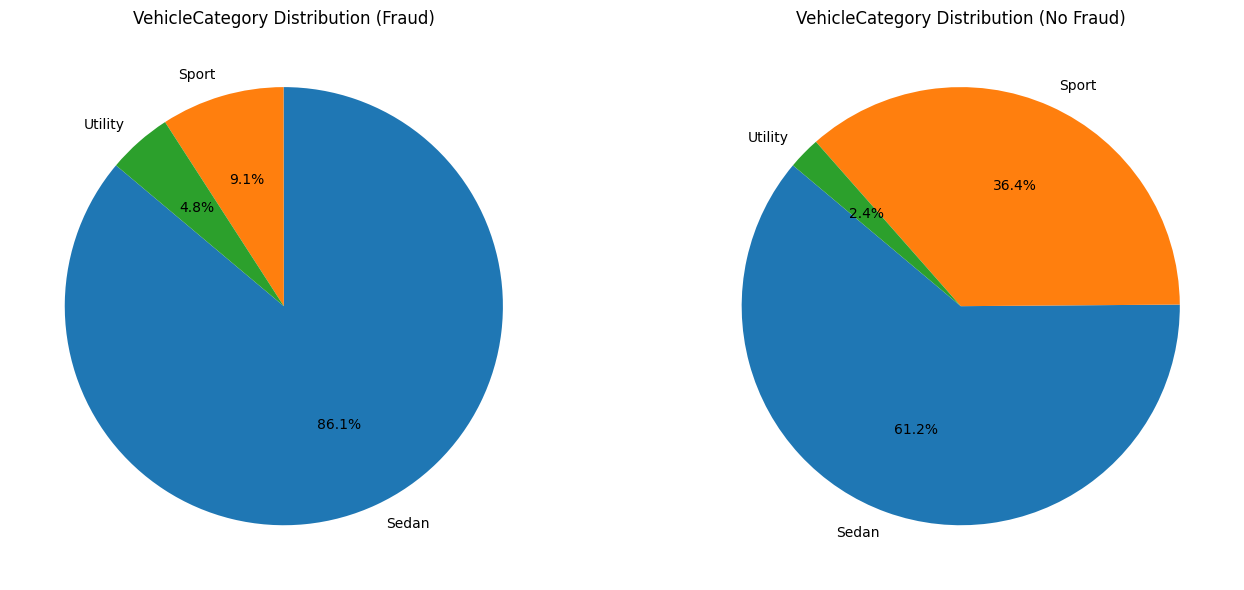

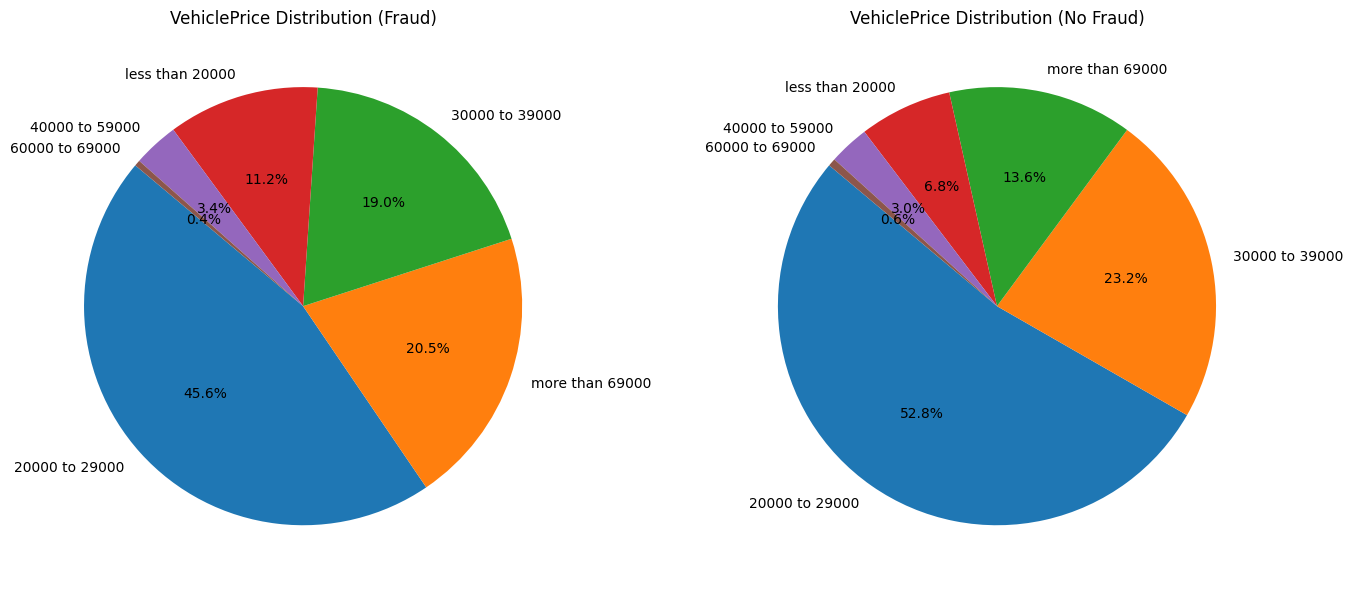

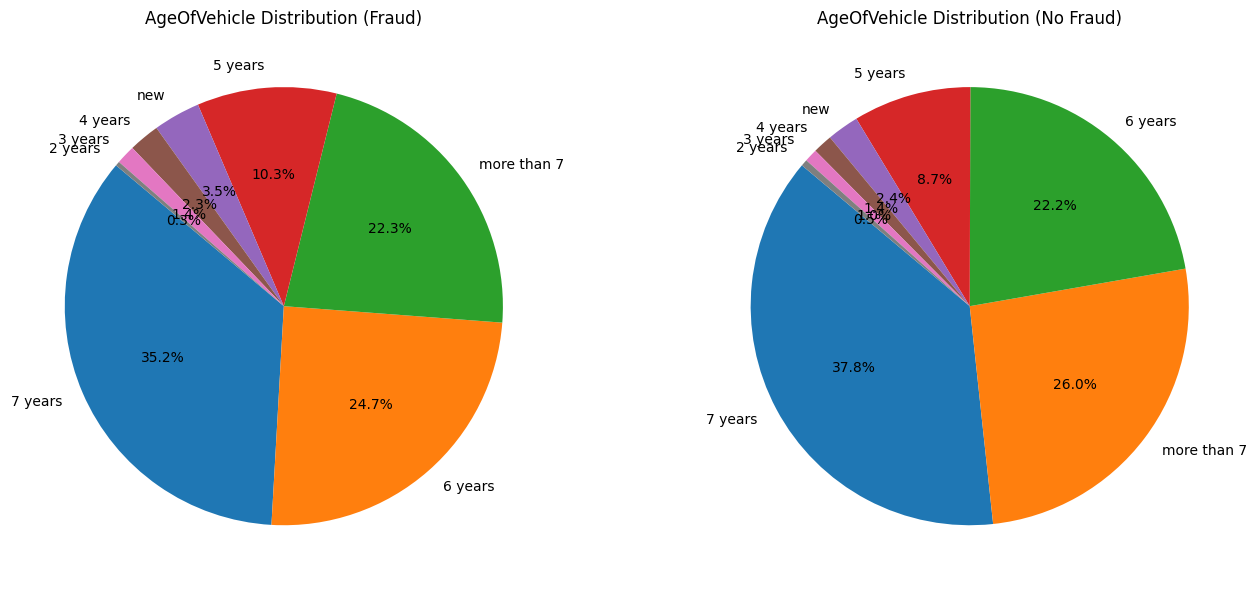

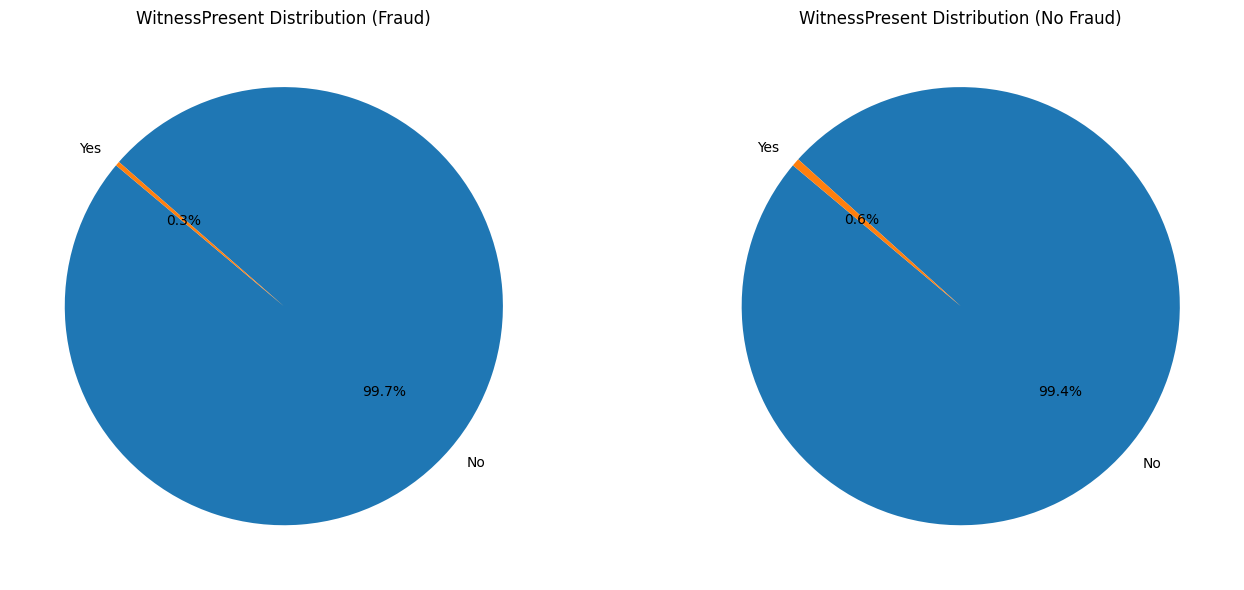

In [453]:
columns = ['VehicleCategory','VehiclePrice','AgeOfVehicle','WitnessPresent']
for col in columns:
    fraud_data = data[data["FraudFound_P"] == 1][col].value_counts()
    no_fraud_data = data[data["FraudFound_P"] == 0][col].value_counts()
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    axes[0].pie(fraud_data, labels=fraud_data.index, autopct='%1.1f%%', startangle=140)
    axes[0].set_title(f'{col} Distribution (Fraud)')

    axes[1].pie(no_fraud_data, labels=no_fraud_data.index, autopct='%1.1f%%', startangle=140)
    axes[1].set_title(f'{col} Distribution (No Fraud)')

    plt.tight_layout()
    plt.show()

We cant really extract a lot from these features, but we will leave them in the dataset for now

## 2. Handling Missing Values

Now we will analyse and handle null values if there are any

In [454]:
data.isna().sum()

Make                    0
AccidentArea            0
Sex                     0
MaritalStatus           0
Age                     0
Fault                   0
PolicyType              0
VehicleCategory         0
VehiclePrice            0
FraudFound_P            0
RepNumber               0
Deductible              0
Days_Policy_Accident    0
Days_Policy_Claim       0
PastNumberOfClaims      0
AgeOfVehicle            0
AgeOfPolicyHolder       0
PoliceReportFiled       0
WitnessPresent          0
AgentType               0
NumberOfSuppliments     0
AddressChange_Claim     0
NumberOfCars            0
BasePolicy              0
dtype: int64

Amazing, there are no null values in our dataset, so we can continue to do encoding on the features that are cathegorical, lets visualise the data again

In [455]:
data.head()

,Make,AccidentArea,Sex,MaritalStatus,Age,Fault,PolicyType,VehicleCategory,VehiclePrice,FraudFound_P,RepNumber,Deductible,Days_Policy_Accident,Days_Policy_Claim,PastNumberOfClaims,AgeOfVehicle,AgeOfPolicyHolder,PoliceReportFiled,WitnessPresent,AgentType,NumberOfSuppliments,AddressChange_Claim,NumberOfCars,BasePolicy
0,Honda,Urban,Female,Single,21,Policy Holder,Sport - Liability,Sport,more than 69000,0,12,300,more than 30,more than 30,none,3 years,26 to 30,No,No,External,none,1 year,3 to 4,Liability
1,Honda,Urban,Male,Single,34,Policy Holder,Sport - Collision,Sport,more than 69000,0,15,400,more than 30,more than 30,none,6 years,31 to 35,Yes,No,External,none,no change,1 vehicle,Collision
2,Honda,Urban,Male,Married,47,Policy Holder,Sport - Collision,Sport,more than 69000,0,7,400,more than 30,more than 30,1,7 years,41 to 50,No,No,External,none,no change,1 vehicle,Collision
3,Toyota,Rural,Male,Married,65,Third Party,Sedan - Liability,Sport,20000 to 29000,0,4,400,more than 30,more than 30,1,more than 7,51 to 65,Yes,No,External,more than 5,no change,1 vehicle,Liability
4,Honda,Urban,Female,Single,27,Third Party,Sport - Collision,Sport,more than 69000,0,3,400,more than 30,more than 30,none,5 years,31 to 35,No,No,External,none,no change,1 vehicle,Collision


## 3. Feature Encoding

In [456]:
for col in data.columns:
    unique_count = data[col].nunique()
    print(f"{col}: {unique_count} unique values")

Make: 19 unique values
AccidentArea: 2 unique values
Sex: 2 unique values
MaritalStatus: 4 unique values
Age: 66 unique values
Fault: 2 unique values
PolicyType: 9 unique values
VehicleCategory: 3 unique values
VehiclePrice: 6 unique values
FraudFound_P: 2 unique values
RepNumber: 16 unique values
Deductible: 4 unique values
Days_Policy_Accident: 5 unique values
Days_Policy_Claim: 4 unique values
PastNumberOfClaims: 4 unique values
AgeOfVehicle: 8 unique values
AgeOfPolicyHolder: 9 unique values
PoliceReportFiled: 2 unique values
WitnessPresent: 2 unique values
AgentType: 2 unique values
NumberOfSuppliments: 4 unique values
AddressChange_Claim: 5 unique values
NumberOfCars: 5 unique values
BasePolicy: 3 unique values


Lets select the features that we are going to label encode, these are features with binary values, ex: yes or no...

In [457]:
le = LabelEncoder()
columns=['AccidentArea','Sex','Fault','PoliceReportFiled','WitnessPresent','AgentType']	
for col in columns:
    data[col]=le.fit_transform(data[col])
data.head()  

,Make,AccidentArea,Sex,MaritalStatus,Age,Fault,PolicyType,VehicleCategory,VehiclePrice,FraudFound_P,RepNumber,Deductible,Days_Policy_Accident,Days_Policy_Claim,PastNumberOfClaims,AgeOfVehicle,AgeOfPolicyHolder,PoliceReportFiled,WitnessPresent,AgentType,NumberOfSuppliments,AddressChange_Claim,NumberOfCars,BasePolicy
0,Honda,1,0,Single,21,0,Sport - Liability,Sport,more than 69000,0,12,300,more than 30,more than 30,none,3 years,26 to 30,0,0,0,none,1 year,3 to 4,Liability
1,Honda,1,1,Single,34,0,Sport - Collision,Sport,more than 69000,0,15,400,more than 30,more than 30,none,6 years,31 to 35,1,0,0,none,no change,1 vehicle,Collision
2,Honda,1,1,Married,47,0,Sport - Collision,Sport,more than 69000,0,7,400,more than 30,more than 30,1,7 years,41 to 50,0,0,0,none,no change,1 vehicle,Collision
3,Toyota,0,1,Married,65,1,Sedan - Liability,Sport,20000 to 29000,0,4,400,more than 30,more than 30,1,more than 7,51 to 65,1,0,0,more than 5,no change,1 vehicle,Liability
4,Honda,1,0,Single,27,1,Sport - Collision,Sport,more than 69000,0,3,400,more than 30,more than 30,none,5 years,31 to 35,0,0,0,none,no change,1 vehicle,Collision


We are going to do ordinal encoding on features that have values that can be organised ordinally

In [458]:

pd.set_option('display.max_columns', None)
for col in ['VehiclePrice','AgeOfVehicle','AgeOfPolicyHolder','Days_Policy_Accident','Days_Policy_Claim','NumberOfCars','NumberOfSuppliments','PastNumberOfClaims',  'AddressChange_Claim']:
    print(data[col].unique())
    print('\n')

['more than 69000' '20000 to 29000' '30000 to 39000' 'less than 20000'
 '40000 to 59000' '60000 to 69000']


['3 years' '6 years' '7 years' 'more than 7' '5 years' 'new' '4 years'
 '2 years']


['26 to 30' '31 to 35' '41 to 50' '51 to 65' '21 to 25' '36 to 40'
 '16 to 17' 'over 65' '18 to 20']


['more than 30' '15 to 30' 'none' '1 to 7' '8 to 15']


['more than 30' '15 to 30' '8 to 15' 'none']


['3 to 4' '1 vehicle' '2 vehicles' '5 to 8' 'more than 8']


['none' 'more than 5' '3 to 5' '1 to 2']


['none' '1' '2 to 4' 'more than 4']


['1 year' 'no change' '4 to 8 years' '2 to 3 years' 'under 6 months']




In [459]:
mappings = {
    'VehiclePrice': {'less than 20000':0,'20000 to 29000':1,'30000 to 39000':2,'40000 to 59000':3,'60000 to 69000':4,'more than 69000':5},  
    'AgeOfVehicle': {'more than 7':0,'7 years':1,'6 years':2,'5 years':3,'4 years':4,'3 years':5,'2 years':6,'new':7},
    'AgeOfPolicyHolder': {'16 to 17':0,'18 to 20':1,'21 to 25':2,'26 to 30':3,'31 to 35':4,'36 to 40':5,'41 to 50':6,'51 to 65':7,'over 65':8},
    'Days_Policy_Accident': {'none':0, '1 to 7':1 ,  '8 to 15':2,'15 to 30':3, 'more than 30':4},
    'Days_Policy_Claim': {'none':0,'8 to 15':1,'15 to 30':2,'more than 30':3},
    'NumberOfCars': {'more than 8':0,'5 to 8':1,'3 to 4':2,'2 vehicles':3,'1 vehicle':4},
    'NumberOfSuppliments': {'none':0,'1 to 2':1,'3 to 5':2,'more than 5':3},
    'PastNumberOfClaims': {'none':0, '1':1 ,'2 to 4':2, 'more than 4':3},
    'AddressChange_Claim': {'1 year':2, 'no change':0, '4 to 8 years':4 ,'2 to 3 years':3, 'under 6 months':1}
}
for col,mapping in mappings.items():
    data[col] = data[col].map(mapping)

In [460]:
data.head()

,Make,AccidentArea,Sex,MaritalStatus,Age,Fault,PolicyType,VehicleCategory,VehiclePrice,FraudFound_P,RepNumber,Deductible,Days_Policy_Accident,Days_Policy_Claim,PastNumberOfClaims,AgeOfVehicle,AgeOfPolicyHolder,PoliceReportFiled,WitnessPresent,AgentType,NumberOfSuppliments,AddressChange_Claim,NumberOfCars,BasePolicy
0,Honda,1,0,Single,21,0,Sport - Liability,Sport,5,0,12,300,4,3,0,5,3,0,0,0,0,2,2,Liability
1,Honda,1,1,Single,34,0,Sport - Collision,Sport,5,0,15,400,4,3,0,2,4,1,0,0,0,0,4,Collision
2,Honda,1,1,Married,47,0,Sport - Collision,Sport,5,0,7,400,4,3,1,1,6,0,0,0,0,0,4,Collision
3,Toyota,0,1,Married,65,1,Sedan - Liability,Sport,1,0,4,400,4,3,1,0,7,1,0,0,3,0,4,Liability
4,Honda,1,0,Single,27,1,Sport - Collision,Sport,5,0,3,400,4,3,0,3,4,0,0,0,0,0,4,Collision


Now we will proceed with the columns that need one hot encoding

In [461]:
columns=['MaritalStatus','PolicyType','VehicleCategory','BasePolicy']
encoder = OneHotEncoder(sparse_output=False)
for col in columns:
    encoded_data = encoder.fit_transform(data[[col]])
    column_names = encoder.get_feature_names_out([col])
    encoded_df = pd.DataFrame(encoded_data, columns=column_names)
    data = data.drop(col,axis=1)
    data = pd.concat([data, encoded_df], axis=1)
data.head()

,Make,AccidentArea,Sex,Age,Fault,VehiclePrice,FraudFound_P,RepNumber,Deductible,Days_Policy_Accident,Days_Policy_Claim,PastNumberOfClaims,AgeOfVehicle,AgeOfPolicyHolder,PoliceReportFiled,WitnessPresent,AgentType,NumberOfSuppliments,AddressChange_Claim,NumberOfCars,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,MaritalStatus_Widow,PolicyType_Sedan - All Perils,PolicyType_Sedan - Collision,PolicyType_Sedan - Liability,PolicyType_Sport - All Perils,PolicyType_Sport - Collision,PolicyType_Sport - Liability,PolicyType_Utility - All Perils,PolicyType_Utility - Collision,PolicyType_Utility - Liability,VehicleCategory_Sedan,VehicleCategory_Sport,VehicleCategory_Utility,BasePolicy_All Perils,BasePolicy_Collision,BasePolicy_Liability
0,Honda,1,0,21,0,5,0,12,300,4,3,0,5,3,0,0,0,0,2,2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,Honda,1,1,34,0,5,0,15,400,4,3,0,2,4,1,0,0,0,0,4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2,Honda,1,1,47,0,5,0,7,400,4,3,1,1,6,0,0,0,0,0,4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
3,Toyota,0,1,65,1,1,0,4,400,4,3,1,0,7,1,0,0,3,0,4,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
4,Honda,1,0,27,1,5,0,3,400,4,3,0,3,4,0,0,0,0,0,4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


In [462]:
data.shape

(15420, 39)

Even though we created a lot of features, we are going to exclude some of them in feature selection so there is no need to worry

Because Mark is a pretty diverse column, having 19 different values for the variables, we are going to use Traget encoding for this feature

In [463]:
#!pip install category_encoders

In [464]:
from sklearn.model_selection import KFold
from category_encoders import TargetEncoder

target_column = 'FraudFound_P'
categorical_column = 'Make'

data[categorical_column + '_encoded'] = np.nan

kf = KFold(n_splits=5, shuffle=True, random_state=42)

for train_index, val_index in kf.split(data):
    X_train, X_val = data.iloc[train_index], data.iloc[val_index]
    encoder = TargetEncoder(cols=[categorical_column])
    encoder.fit(X_train[categorical_column], X_train[target_column])
    data.loc[val_index, categorical_column + '_encoded'] = encoder.transform(X_val[categorical_column])[categorical_column].values

data.drop(columns=[categorical_column], inplace=True)
data.rename(columns={categorical_column + '_encoded': categorical_column}, inplace=True)

In [465]:
data.head()

,AccidentArea,Sex,Age,Fault,VehiclePrice,FraudFound_P,RepNumber,Deductible,Days_Policy_Accident,Days_Policy_Claim,PastNumberOfClaims,AgeOfVehicle,AgeOfPolicyHolder,PoliceReportFiled,WitnessPresent,AgentType,NumberOfSuppliments,AddressChange_Claim,NumberOfCars,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,MaritalStatus_Widow,PolicyType_Sedan - All Perils,PolicyType_Sedan - Collision,PolicyType_Sedan - Liability,PolicyType_Sport - All Perils,PolicyType_Sport - Collision,PolicyType_Sport - Liability,PolicyType_Utility - All Perils,PolicyType_Utility - Collision,PolicyType_Utility - Liability,VehicleCategory_Sedan,VehicleCategory_Sport,VehicleCategory_Utility,BasePolicy_All Perils,BasePolicy_Collision,BasePolicy_Liability,Make
0,1,0,21,0,5,0,12,300,4,3,0,5,3,0,0,0,0,2,2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.062472
1,1,1,34,0,5,0,15,400,4,3,0,2,4,1,0,0,0,0,4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.061767
2,1,1,47,0,5,0,7,400,4,3,1,1,6,0,0,0,0,0,4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.064473
3,0,1,65,1,1,0,4,400,4,3,1,0,7,1,0,0,3,0,4,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.061489
4,1,0,27,1,5,0,3,400,4,3,0,3,4,0,0,0,0,0,4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.061767


## 4. Data Scaling

Now that we have encoded our features, lets standardise and normalise the appropriate ones

In [466]:
ss = StandardScaler()
ns = MinMaxScaler()

columns = ['RepNumber','Age','VehiclePrice','AgeOfVehicle','AgeOfPolicyHolder','Days_Policy_Accident','Days_Policy_Claim','NumberOfCars','NumberOfSuppliments']

for col in columns:
    data[[col]] = ns.fit_transform(data[[col]])

data[['Deductible']] = ss.fit_transform(data[['Deductible']])



In [467]:
data.head()

,AccidentArea,Sex,Age,Fault,VehiclePrice,FraudFound_P,RepNumber,Deductible,Days_Policy_Accident,Days_Policy_Claim,PastNumberOfClaims,AgeOfVehicle,AgeOfPolicyHolder,PoliceReportFiled,WitnessPresent,AgentType,NumberOfSuppliments,AddressChange_Claim,NumberOfCars,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,MaritalStatus_Widow,PolicyType_Sedan - All Perils,PolicyType_Sedan - Collision,PolicyType_Sedan - Liability,PolicyType_Sport - All Perils,PolicyType_Sport - Collision,PolicyType_Sport - Liability,PolicyType_Utility - All Perils,PolicyType_Utility - Collision,PolicyType_Utility - Liability,VehicleCategory_Sedan,VehicleCategory_Sport,VehicleCategory_Utility,BasePolicy_All Perils,BasePolicy_Collision,BasePolicy_Liability,Make
0,1,0,0.2625,0,1.0,0,0.733333,-2.450633,1.0,1.0,0,0.714286,0.375,0,0,0,0.0,2,0.5,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.062472
1,1,1,0.4250,0,1.0,0,0.933333,-0.175298,1.0,1.0,0,0.285714,0.500,1,0,0,0.0,0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.061767
2,1,1,0.5875,0,1.0,0,0.400000,-0.175298,1.0,1.0,1,0.142857,0.750,0,0,0,0.0,0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.064473
3,0,1,0.8125,1,0.2,0,0.200000,-0.175298,1.0,1.0,1,0.000000,0.875,1,0,0,1.0,0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.061489
4,1,0,0.3375,1,1.0,0,0.133333,-0.175298,1.0,1.0,0,0.428571,0.500,0,0,0,0.0,0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.061767


## Correlation Matrix

## 5. Data Split

In [468]:
X = data.drop('FraudFound_P',axis=1)
y = data[['FraudFound_P']]

In [469]:
X.head()

,AccidentArea,Sex,Age,Fault,VehiclePrice,RepNumber,Deductible,Days_Policy_Accident,Days_Policy_Claim,PastNumberOfClaims,AgeOfVehicle,AgeOfPolicyHolder,PoliceReportFiled,WitnessPresent,AgentType,NumberOfSuppliments,AddressChange_Claim,NumberOfCars,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,MaritalStatus_Widow,PolicyType_Sedan - All Perils,PolicyType_Sedan - Collision,PolicyType_Sedan - Liability,PolicyType_Sport - All Perils,PolicyType_Sport - Collision,PolicyType_Sport - Liability,PolicyType_Utility - All Perils,PolicyType_Utility - Collision,PolicyType_Utility - Liability,VehicleCategory_Sedan,VehicleCategory_Sport,VehicleCategory_Utility,BasePolicy_All Perils,BasePolicy_Collision,BasePolicy_Liability,Make
0,1,0,0.2625,0,1.0,0.733333,-2.450633,1.0,1.0,0,0.714286,0.375,0,0,0,0.0,2,0.5,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.062472
1,1,1,0.4250,0,1.0,0.933333,-0.175298,1.0,1.0,0,0.285714,0.500,1,0,0,0.0,0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.061767
2,1,1,0.5875,0,1.0,0.400000,-0.175298,1.0,1.0,1,0.142857,0.750,0,0,0,0.0,0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.064473
3,0,1,0.8125,1,0.2,0.200000,-0.175298,1.0,1.0,1,0.000000,0.875,1,0,0,1.0,0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.061489
4,1,0,0.3375,1,1.0,0.133333,-0.175298,1.0,1.0,0,0.428571,0.500,0,0,0,0.0,0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.061767


In [470]:
y.head()

,FraudFound_P
0,0
1,0
2,0
3,0
4,0


In [471]:
X_work, X_test, y_work, y_test = train_test_split(X,y,test_size=0.2, stratify=y, shuffle=True, random_state=38)

In [472]:
X_train, X_val, y_train, y_val = train_test_split(X_work,y_work,test_size=0.3, stratify=y_work, shuffle=True, random_state=38)

## Feature Selection and Importance

In [473]:

original_categorical_cols = [
    'MaritalStatus', 'PolicyType', 'VehicleCategory','BasePolicy'
]


one_hot_columns = [col for col in X.columns if any(col.startswith(base) for base in original_categorical_cols)]

print("One-hot encoded columns:")
print(one_hot_columns)
print()

One-hot encoded columns:
['MaritalStatus_Divorced', 'MaritalStatus_Married', 'MaritalStatus_Single', 'MaritalStatus_Widow', 'PolicyType_Sedan - All Perils', 'PolicyType_Sedan - Collision', 'PolicyType_Sedan - Liability', 'PolicyType_Sport - All Perils', 'PolicyType_Sport - Collision', 'PolicyType_Sport - Liability', 'PolicyType_Utility - All Perils', 'PolicyType_Utility - Collision', 'PolicyType_Utility - Liability', 'VehicleCategory_Sedan', 'VehicleCategory_Sport', 'VehicleCategory_Utility', 'BasePolicy_All Perils', 'BasePolicy_Collision', 'BasePolicy_Liability']



In [474]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(random_state=38)

excluded = one_hot_columns
X_filtered = X_train.drop(columns=excluded,axis=1)
feature_names = X_filtered.columns

model.fit(X_filtered, y_train)
importances = model.feature_importances_


feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

print(feature_importance_df.head(10))  

C:\Users\david\AppData\Roaming\Python\Python312\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


                Feature  Importance
18                 Make    0.207493
2                   Age    0.177562
5             RepNumber    0.171465
10         AgeOfVehicle    0.069196
15  NumberOfSuppliments    0.065122
9    PastNumberOfClaims    0.060500
4          VehiclePrice    0.059451
11    AgeOfPolicyHolder    0.050733
3                 Fault    0.025540
16  AddressChange_Claim    0.021418


In [475]:
br = 0
column_names = []
for col in feature_importance_df['Feature']:
    column_names.append(col)
    br += 1
    if br == 10:
        break

print(column_names)

column_names = column_names + one_hot_columns

print(column_names)

['Make', 'Age', 'RepNumber', 'AgeOfVehicle', 'NumberOfSuppliments', 'PastNumberOfClaims', 'VehiclePrice', 'AgeOfPolicyHolder', 'Fault', 'AddressChange_Claim']
['Make', 'Age', 'RepNumber', 'AgeOfVehicle', 'NumberOfSuppliments', 'PastNumberOfClaims', 'VehiclePrice', 'AgeOfPolicyHolder', 'Fault', 'AddressChange_Claim', 'MaritalStatus_Divorced', 'MaritalStatus_Married', 'MaritalStatus_Single', 'MaritalStatus_Widow', 'PolicyType_Sedan - All Perils', 'PolicyType_Sedan - Collision', 'PolicyType_Sedan - Liability', 'PolicyType_Sport - All Perils', 'PolicyType_Sport - Collision', 'PolicyType_Sport - Liability', 'PolicyType_Utility - All Perils', 'PolicyType_Utility - Collision', 'PolicyType_Utility - Liability', 'VehicleCategory_Sedan', 'VehicleCategory_Sport', 'VehicleCategory_Utility', 'BasePolicy_All Perils', 'BasePolicy_Collision', 'BasePolicy_Liability']


In [476]:
for col in data.columns:
    if col not in column_names and col != 'FraudFound_P':
        X_val = X_val.drop(col,axis=1)
        X_test = X_test.drop(col,axis=1)
        X_train = X_train.drop(col,axis=1)

In [477]:
X_train.shape

(8635, 29)

## Class Balancing

Now lets check the balance of the target variable and if need be do some sampling

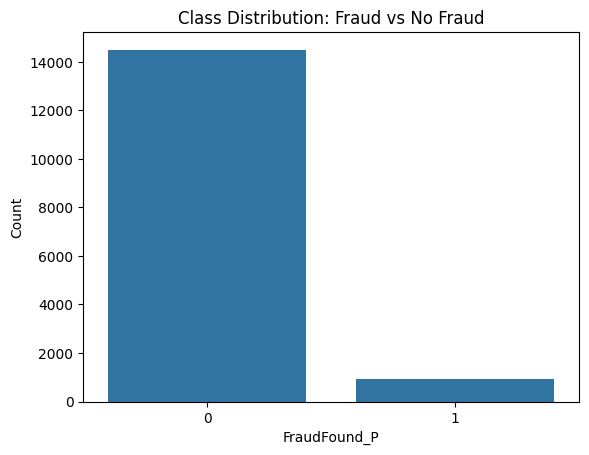

FraudFound_P
0    94.014267
1     5.985733
Name: proportion, dtype: float64


In [478]:

sns.countplot(x='FraudFound_P', data=data)
plt.title('Class Distribution: Fraud vs No Fraud')
plt.xlabel('FraudFound_P')
plt.ylabel('Count')
plt.show()


print(data['FraudFound_P'].value_counts(normalize=True) * 100)

As we can see the class is not at all evenly distributed, so we are going to use a combination of undersampling and oversampling

In [479]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

sm = SMOTE(random_state=38)
X_res, y_res = sm.fit_resample(X_train, y_train)

rus = RandomUnderSampler(random_state=38)
X_res, y_res = rus.fit_resample(X_res, y_res)

C:\Users\david\AppData\Roaming\Python\Python312\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
C:\Users\david\AppData\Roaming\Python\Python312\site-packages\sklearn\base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
C:\Users\david\AppData\Roaming\Python\Python312\site-packages\sklearn\base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(


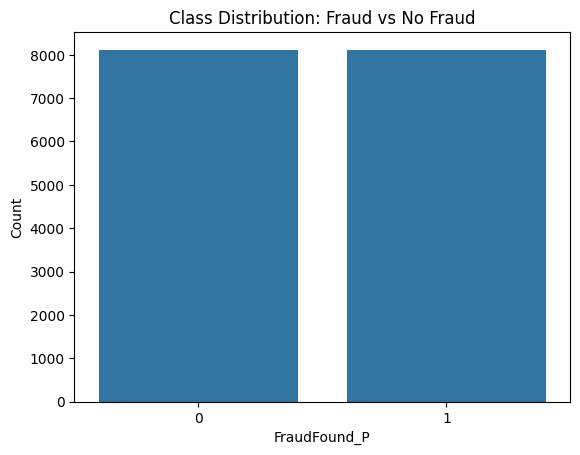

FraudFound_P
0    50.0
1    50.0
Name: proportion, dtype: float64


In [480]:
data_res = pd.concat([X_res, y_res], axis=1)

# Plot class distribution
sns.countplot(x='FraudFound_P', data=data_res)
plt.title('Class Distribution: Fraud vs No Fraud')
plt.xlabel('FraudFound_P')
plt.ylabel('Count')
plt.show()

# Print class balance in %
print(data_res['FraudFound_P'].value_counts(normalize=True) * 100)

In [481]:
data_res.shape

(16236, 30)

C:\Users\david\AppData\Roaming\Python\Python312\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Accuracy Score: 0.9999

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      8118
           1       1.00      1.00      1.00      8118

    accuracy                           1.00     16236
   macro avg       1.00      1.00      1.00     16236
weighted avg       1.00      1.00      1.00     16236



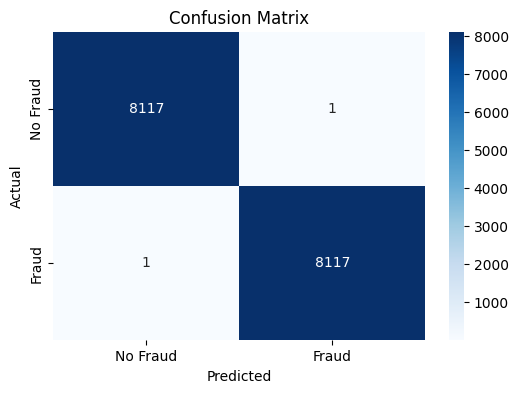

In [483]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# Train the Random Forest model
rf = RandomForestClassifier(random_state=38)
rf.fit(X_res, y_res)

# Predict on the test set
y_pred = rf.predict(X_res)

# Accuracy
acc = accuracy_score(y_res, y_pred)
print(f"Accuracy Score: {acc:.4f}")

# Classification Report
print("\nClassification Report:")
print(classification_report(y_res, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_res, y_pred)

# Plot confusion matrix as heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Fraud', 'Fraud'], yticklabels=['No Fraud', 'Fraud'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()